In [2]:
!python heat_sink.py

/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
[W205 12:34:10.754761323 init.cpp:767] Warning: nvfuser is no longer supported in torch script, use _jit_set_nvfuser_enabled is deprecated and a no-op (function operator())
[12:34:10] - JitManager: {'_enabled': False, '_arch_mode': <JitArchMode.ONLY_ACTIVATION: 1>, '_use_nvfuser': True, '_autograd_nodes': False}
[12:34:10] - GraphManager: {'_func_arch': False, '_debug': False, '_func_arch_allow_partial_hessian': True}
[12:34:10] - AmpManager: {'_enabled': False, '_mode': <AmpMode.PER_ORDER_SCALER: 0>, '_dtype': torch.float16, '_default_max_scale': 1, '_autocast_activation': False, '_autocast_firstlayer': False, '_special_terms': [], '_custom_max_scales': {}}
/workspace/modulus-sym/examples/three_fin_2d

In [2]:
!tensorboard --logdir=./ --port=7007

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.16.2 at http://c7012b3fad47:7007/ (Press CTRL+C to quit)
^C


### plot

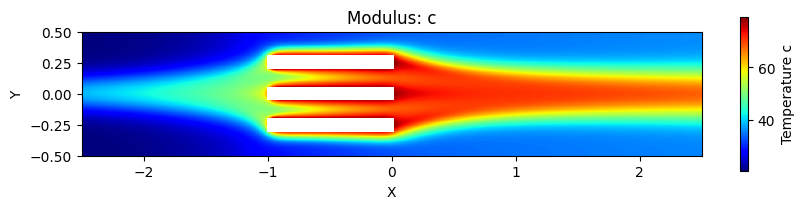

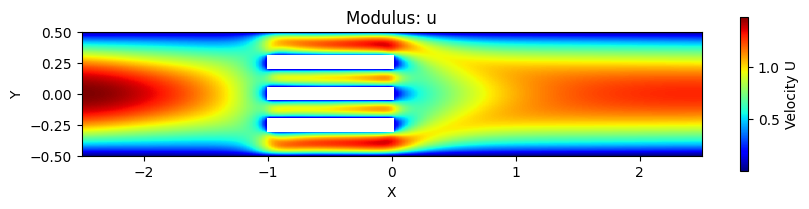

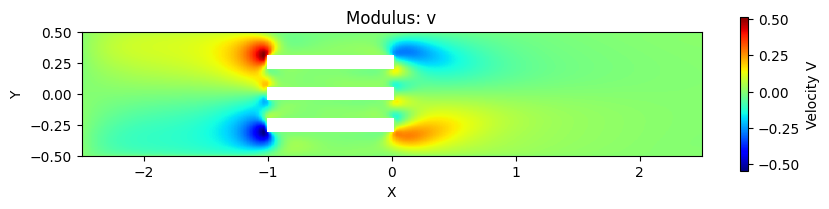

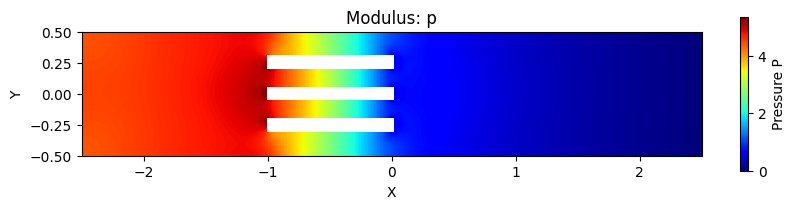

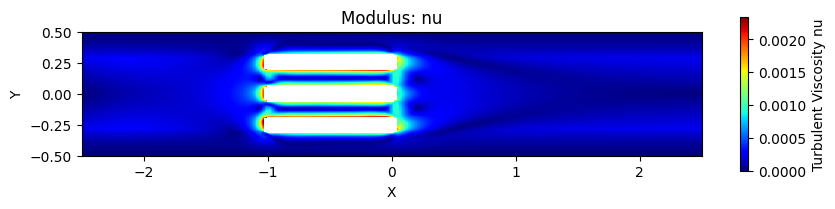

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from modulus.sym.geometry.primitives_2d import Rectangle, Channel2D
from modulus.sym.key import Key
from modulus.sym.hydra import ModulusConfig
from modulus.sym.models.fully_connected import FullyConnectedArch
from modulus.sym.models.activation import Activation

# Load the model weights
heat_weights_path = "/workspace/modulus-sym/examples/three_fin_2d/outputs/heat_sink/heat_network.0.pth"
flow_weights_path = "/workspace/modulus-sym/examples/three_fin_2d/outputs/heat_sink/flow_network.0.pth"
heat_weights = torch.load(heat_weights_path, weights_only=True)
flow_weights = torch.load(flow_weights_path, weights_only=True)

# Define model architectures
heat_net = FullyConnectedArch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("c")],
    layer_size=512,
    nr_layers=6,
    skip_connections=False,
    activation_fn=Activation.SILU,
    adaptive_activations=False,
    weight_norm=True
)
heat_net.load_state_dict(heat_weights)

flow_net = FullyConnectedArch(
    input_keys=[Key("x"), Key("y")],
    output_keys=[Key("u"), Key("v"), Key("p")],
    layer_size=512,
    nr_layers=6,
    skip_connections=False,
    activation_fn=Activation.SILU,
    adaptive_activations=False,
    weight_norm=True
)
flow_net.load_state_dict(flow_weights)


# Define the domain for visualization
channel_length = (-2.5, 2.5)
channel_width = (-0.5, 0.5)
heat_sink_origin = (-1, -0.3)
nr_heat_sink_fins = 3
gap = 0.15 + 0.1
heat_sink_length = 1.0
heat_sink_fin_thickness = 0.1

channel = Channel2D(
    (channel_length[0], channel_width[0]), (channel_length[1], channel_width[1])
)
heat_sink = Rectangle(
    heat_sink_origin,
    (heat_sink_origin[0] + heat_sink_length, heat_sink_origin[1] + heat_sink_fin_thickness),
)
for i in range(1, nr_heat_sink_fins):
    heat_sink_origin = (heat_sink_origin[0], heat_sink_origin[1] + gap)
    fin = Rectangle(
        heat_sink_origin,
        (heat_sink_origin[0] + heat_sink_length, heat_sink_origin[1] + heat_sink_fin_thickness),
    )
    heat_sink = heat_sink + fin

geo = channel - heat_sink  # Exclude heat sink from domain


# Generate grid
num_x, num_y = 200, 100
x_grid, y_grid = np.meshgrid(np.linspace(*channel_length, num_x), np.linspace(*channel_width, num_y))

# Predict fields
inputs = {"x": torch.tensor(x_grid.flatten(), dtype=torch.float32).reshape(-1, 1),
          "y": torch.tensor(y_grid.flatten(), dtype=torch.float32).reshape(-1, 1)}
with torch.no_grad():
    grid_C = heat_net(inputs)["c"].numpy().reshape(num_y, num_x)
    outputs = flow_net(inputs)
    grid_U = outputs["u"].numpy().reshape(num_y, num_x)
    grid_V = outputs["v"].numpy().reshape(num_y, num_x)
    grid_P = outputs["p"].numpy().reshape(num_y, num_x)

# Define heat sink mask
heat_sink_mask = np.zeros_like(x_grid)
heat_sink_x_min = -1
heat_sink_x_max = -1 + heat_sink_length
heat_sink_y_min = -0.3
heat_sink_y_max = heat_sink_y_min + heat_sink_fin_thickness

for i in range(nr_heat_sink_fins):
    heat_sink_mask[(x_grid >= heat_sink_x_min) & (x_grid <= heat_sink_x_max) & 
                   (y_grid >= heat_sink_y_min) & (y_grid <= heat_sink_y_max)] = 1
    heat_sink_y_min += gap
    heat_sink_y_max += gap

grid_C[heat_sink_mask == 1] = np.nan
grid_U[heat_sink_mask == 1] = np.nan
grid_V[heat_sink_mask == 1] = np.nan
grid_P[heat_sink_mask == 1] = np.nan


# Compute velocity gradients
du_dx, du_dy = np.gradient(grid_U, axis=(1, 0))
dv_dx, dv_dy = np.gradient(grid_V, axis=(1, 0))

# Compute turbulence generation term G
G = 2 * du_dx**2 + 2 * dv_dy**2 + (du_dy + dv_dx)**2

# Define wall distance approximation (assuming symmetric channel)
wall_distance = np.minimum(y_grid - channel_width[0], channel_width[1] - y_grid)

# Compute mixing length l_m
karman_constant = 0.419
max_distance_ratio = 0.09
max_distance = channel_width[1] - channel_width[0]  # Assuming full channel height
mixing_length = np.minimum(karman_constant * wall_distance, max_distance_ratio * max_distance)

# Compute eddy viscosity nu_t
nu_t = mixing_length**2 * np.sqrt(G)

# Apply mask
nu_t[heat_sink_mask == 1] = np.nan

# Plot results
def plot_field(data, title, label):
    plt.figure(figsize=(10, 2))
    im = plt.imshow(data, extent=[-2.5, 2.5, -0.5, 0.5], origin='lower', cmap='jet', aspect='auto')
    plt.colorbar(im, label=label)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.show()

plot_field(grid_C * 273.15 + 293.498 -273.15, "Modulus: c", "Temperature c")
plot_field(grid_U, "Modulus: u", "Velocity U")
plot_field(grid_V, "Modulus: v", "Velocity V")
plot_field(grid_P, "Modulus: p", "Pressure P")
plot_field(nu_t, "Modulus: nu", "Turbulent Viscosity nu")
